# Taxi demand prediction at airports

Sweet Lift Taxi company has collected historical data on taxi orders at airports. In order to attract more drivers during peak hours, we need to predict the number of taxi orders for the next hour. Build a model for this prediction.

- The RECM metric on the test set should not exceed 48.

# Data Description

- Data is stored in the file `taxi.csv`.
- The number of orders is on column `num_orders`.

# Initialization

In [181]:
# Load libraries

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Load data

In [182]:
# Load the data into DataFrames taking into account that the first column is of type datetime
df = pd.read_csv('../datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [183]:
# Print the general/summary information about the DataFrame
df.info()

# Print a random sample of 5 rows from the DataFrame
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-07-10 18:00:00,11
2018-06-29 07:50:00,13
2018-04-22 10:40:00,7
2018-07-04 13:50:00,6
2018-06-14 21:00:00,18


## Intermediate Conclusion

- The first column of type `Datetime` was used as the index.
- There are no null values in the only column `num_orders`, and it is of the correct data type.

# Prepare data

In [184]:
# Sort the DataFrame by date using the index
df = df.sort_index()

In [185]:
# Perform data resampling to 1 hour
df = df.resample('1H').sum()

In [186]:
# Print the general/summary information about the DataFrame
df.info()

# Print the first 5 rows of the DataFrame
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Observations

- After applying resampling for one hour, there are `4416` records in the DataFrame.
- The DataFrame contains dates from `2018-03-01` to `2018-08-31`.

# EDA

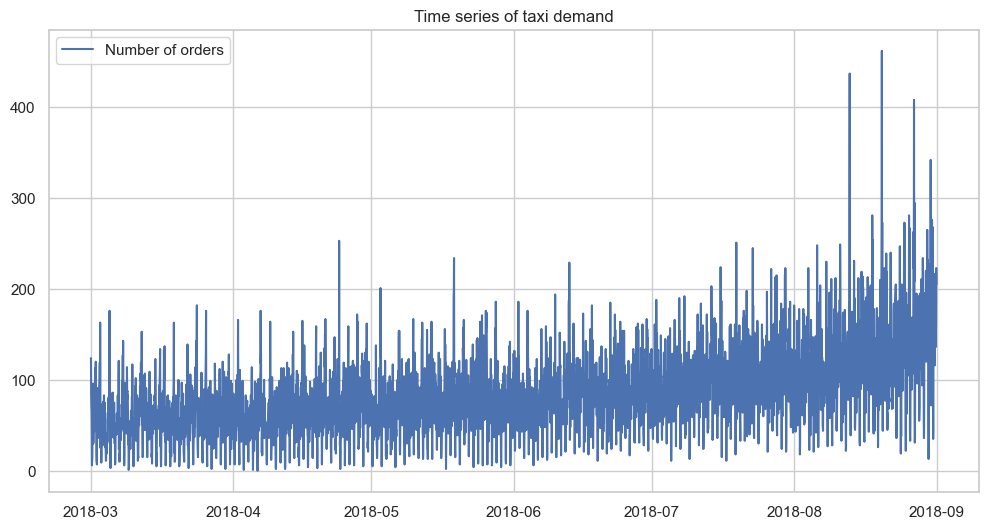

In [187]:
# Create a time series plot of the number of orders
plt.figure(figsize=(12, 6))
plt.title('Time series of taxi demand')
plt.plot(df.index, df['num_orders'], label='Number of orders')
plt.legend()
plt.show()

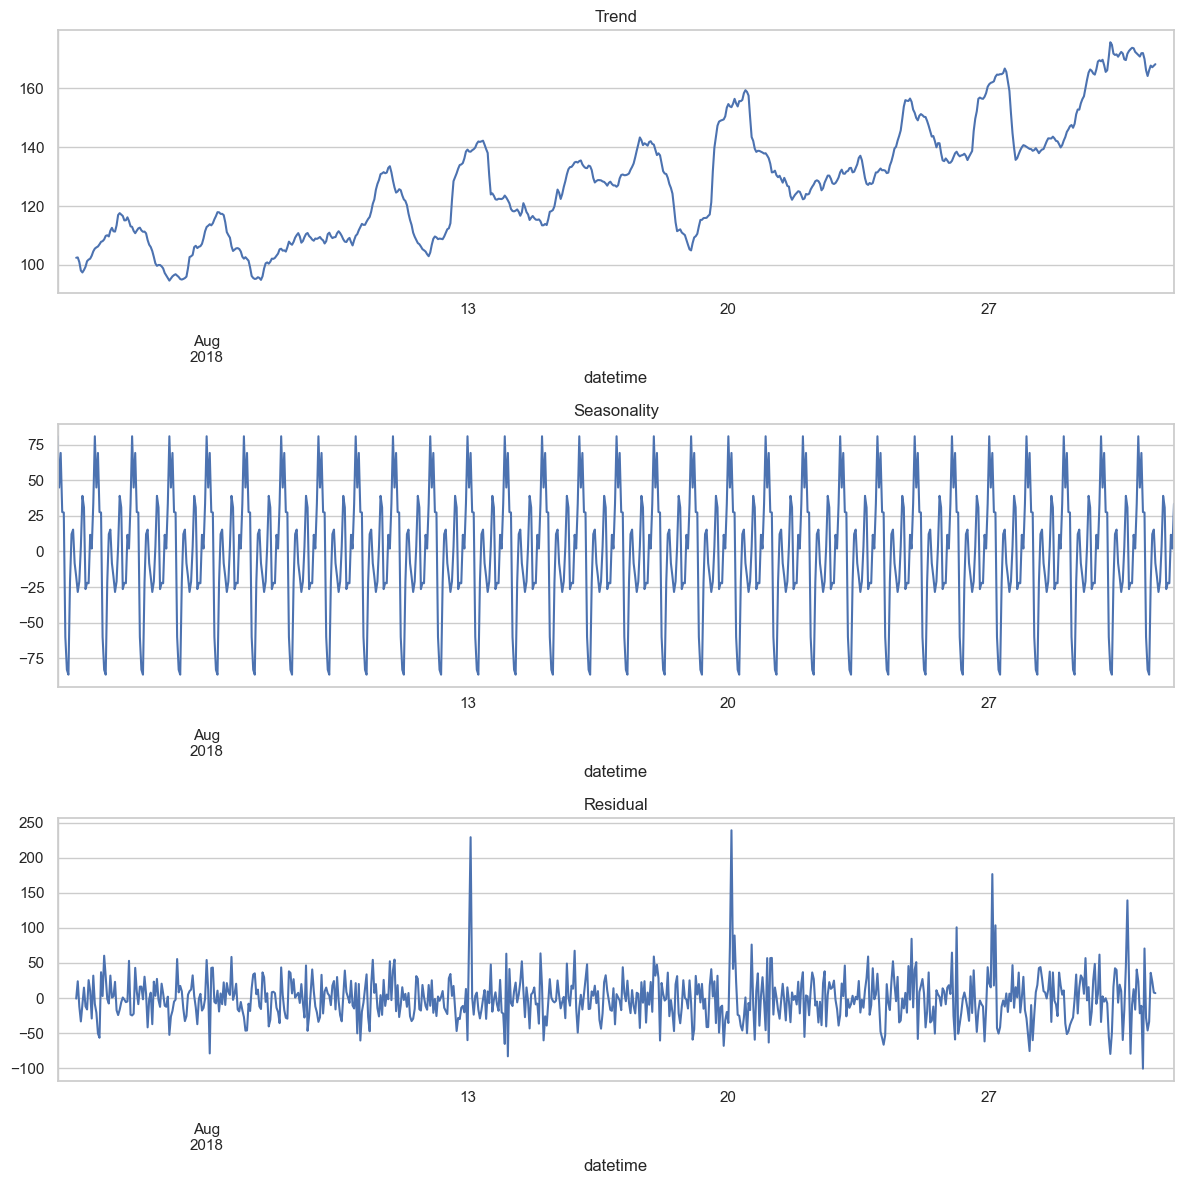

In [188]:
# Create trend, seasonality, and residual plots for the num_orders column for the last month
decomposed = seasonal_decompose(df['num_orders'][-720:])

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.tight_layout()

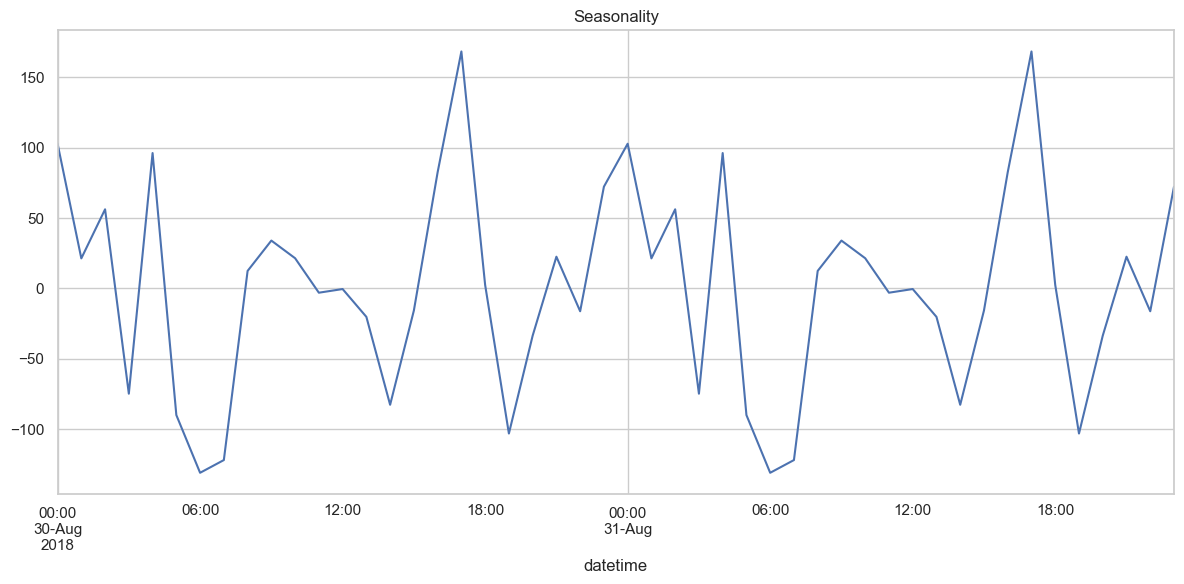

In [189]:
# Create a seasonality plot for the num_orders column for the last 2 days
decomposed = seasonal_decompose(df['num_orders'][-48:])

plt.figure(figsize=(12, 6))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

## Intermediate Conclusion

By performing trend and seasonality analysis, as well as graphing the complete dataset, we narrowed down the data to one month and two days in order to observe these patterns more clearly.

Based on the analysis, it can be noted that:
- There is an increasing trend in the number of orders over the months (at least within the provided data range).
- Seasonality reflects a daily cycle.
- During the day, peak ordering hours occur around `18:00` hrs.

Considering these observations, it would be useful to create new features (lag and rolling mean) since there is a clear pattern of seasonality.

**NOTE:** In order to identify any larger-scale seasonality, such as between the first and last months of the year, it would be necessary to have data covering a wider time range.

# Feature Engineering

In [190]:
# Features of the date
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

# Features of a 24-hour time lag
df['lag_24'] = df['num_orders'].shift(24)

# Features of a 48-hour time lag
df['lag_48'] = df['num_orders'].shift(48)

# Features of a 72-hour time lag
df['lag_72'] = df['num_orders'].shift(72)

# Features of a 24-hour rolling mean
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()

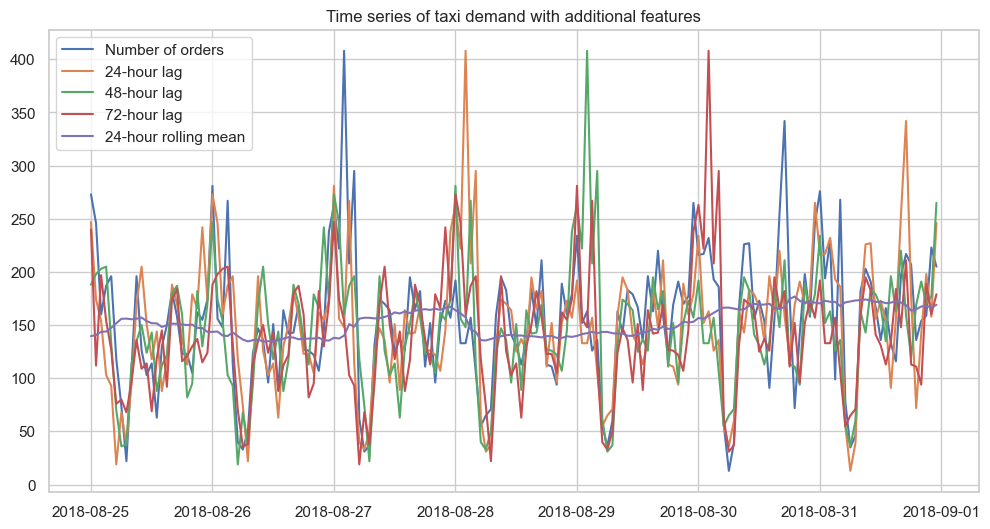

In [191]:
# Create a time series plot of taxi demand with the additional features (last 7 days)
plt.figure(figsize=(12, 6))
plt.title('Time series of taxi demand with additional features')
plt.plot(df.index[-168:], df['num_orders'][-168:], label='Number of orders')
plt.plot(df.index[-168:], df['lag_24'][-168:], label='24-hour lag')
plt.plot(df.index[-168:], df['lag_48'][-168:], label='48-hour lag')
plt.plot(df.index[-168:], df['lag_72'][-168:], label='72-hour lag')
plt.plot(df.index[-168:], df['rolling_mean'][-168:], label='24-hour rolling mean')
plt.legend()
plt.show()

In [192]:
# Make sure to drop all rows with missing values
df = df.dropna()

# Model construction

In [193]:
# Set random seed for reproducibility
random_state = 12345

## Data Segmentation

In [194]:
# Separate the data into features and target
features = df.drop('num_orders', axis=1)
target = df['num_orders']

# Divide the data into training and test sets (90% and 10%)
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1, random_state=random_state)

## Find the best hyperparameters

In [195]:
# Set the scoring metric to be used for choosing the best hyperparameters
scoring = 'neg_mean_squared_error'

In [196]:
# Create a function to calculate the best hyperparameters for a list of models
def find_best_params(models, train_features, train_targets, scoring):
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Model', 'Best Parameters', 'Best Score'])

    # Iterate through the list of models
    for model in models:
        # Print the name of the model
        print(f"Finding best parameters for {type(model['model']).__name__}...")

        # Perform a grid search of the hyperparameters
        grid = GridSearchCV(model['model'], model['param_grid'], cv=5, scoring=scoring, verbose=0, n_jobs=-1)
        grid.fit(train_features, train_targets)

        # Extract best parameters and score
        best_params = grid.best_params_
        best_score = np.abs(grid.best_score_)

        # Store the results in the DataFrame
        results = pd.concat([results, pd.DataFrame({'Model': type(model['model']).__name__, 
                                  'Best Parameters': [best_params], 
                                  'Best Score': best_score})], ignore_index=True)

        # Sort the DataFrame by best score
        results.sort_values(by='Best Score', ascending=False, inplace=True)

    # Create a bar plot to visualize the best scores
    plt.figure(figsize=(12, 10))
    sns.barplot(data=results, x='Model', y='Best Score', palette="coolwarm")
    plt.title("Grid Search Results")
    plt.xticks(rotation=45)
    plt.tight_layout()

    return results

Finding best parameters for LinearRegression...
Finding best parameters for RandomForestRegressor...
Finding best parameters for CatBoostRegressor...
Finding best parameters for XGBRegressor...


,Model,Best Parameters,Best Score
3,XGBRegressor,"{'max_depth': 3, 'n_estimators': 50}",668.579129
0,RandomForestRegressor,"{'max_depth': 7, 'n_estimators': 200}",620.711800
1,CatBoostRegressor,"{'depth': 3, 'iterations': 50}",619.906713
2,LinearRegression,{},600.412146


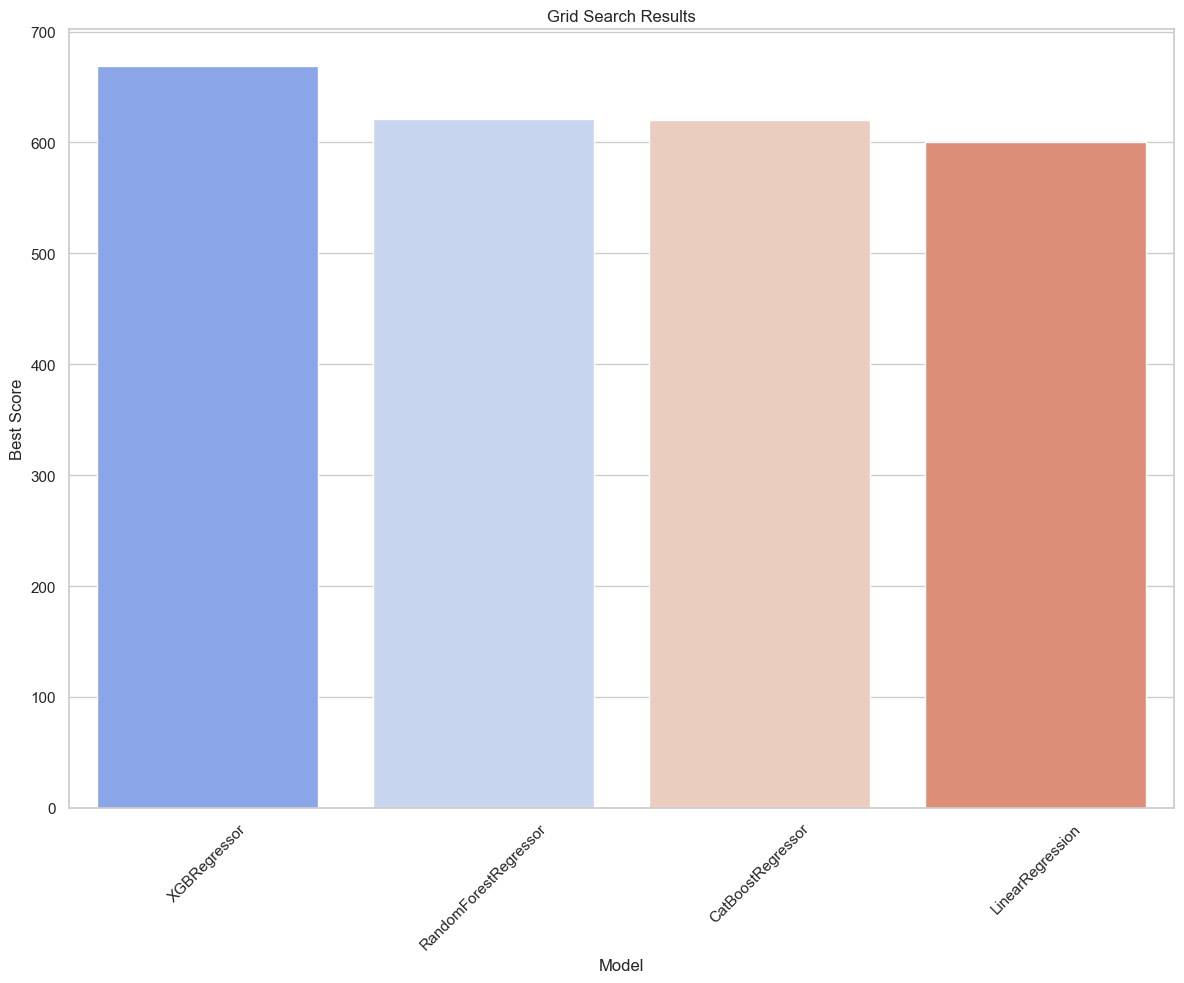

In [197]:
# Define the models and their basic hyperparameters
models = [
    {
        'model': LinearRegression(),
        'param_grid': {}
    },
    {
        'model': RandomForestRegressor(random_state=random_state),
        'param_grid': {'n_estimators': np.arange(50, 201, 50), 'max_depth': np.arange(3, 15)}
    },
    {
        'model': CatBoostRegressor(random_state=random_state, silent=True),
        'param_grid':  {'iterations': np.arange(50, 201, 50), 'depth': np.arange(3, 15)}
    },
    {
        'model': xgb.XGBRegressor(random_state=random_state),
        'param_grid': {'n_estimators': np.arange(50, 201, 50), 'max_depth': np.arange(3, 15)}
    },
]

# Find the best hyperparameters for each model
results = find_best_params(models, features_train, target_train, scoring)

# Print the results
results

In [198]:
# Set the index of the DataFrame to the model name
results.set_index('Model', inplace=True)

# Set the hyperparameters for each model based on the results of the grid search
models = [
    LinearRegression(**results.loc['LinearRegression']['Best Parameters']),
    RandomForestRegressor(random_state=random_state, **results.loc['RandomForestRegressor']['Best Parameters']),
    CatBoostRegressor(random_state=random_state, **results.loc['CatBoostRegressor']['Best Parameters'], silent=True),
    xgb.XGBRegressor(random_state=random_state, **results.loc['XGBRegressor']['Best Parameters']),
]

## Train and evaluate models

In [199]:
# Create a function to train and evaluate multiple models on the training and validation subsets and create a graph to visualize the results
def train_and_evaluate_models(models, features_train, target_train, features_valid, target_valid):
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R2', 'RMSE'])
    
    # Loop through each model
    for model in models:
        # Train the model
        model.fit(features_train, target_train)
        
        # Make predictions
        predictions = model.predict(features_valid)
        
        # Evaluate the model
        mae = mean_absolute_error(target_valid, predictions)
        mse = mean_squared_error(target_valid, predictions)
        r2 = r2_score(target_valid, predictions)
        rmse = np.sqrt(mse)
        
        # Append the results to the DataFrame
        results = pd.concat([results, pd.DataFrame({
            'Model': model.__class__.__name__, 'MAE': mae, 'MSE': mse, 'R2': r2, 'RMSE': rmse}, index=[0])], ignore_index=True)
    
    # Draw a heatmap to visualize the results
    plt.figure(figsize=(14,7))
    sns.set(style="whitegrid")
    sns.heatmap(results.set_index('Model'), annot=True, cmap='RdBu_r')
    plt.title('Model Comparison')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()

    return results

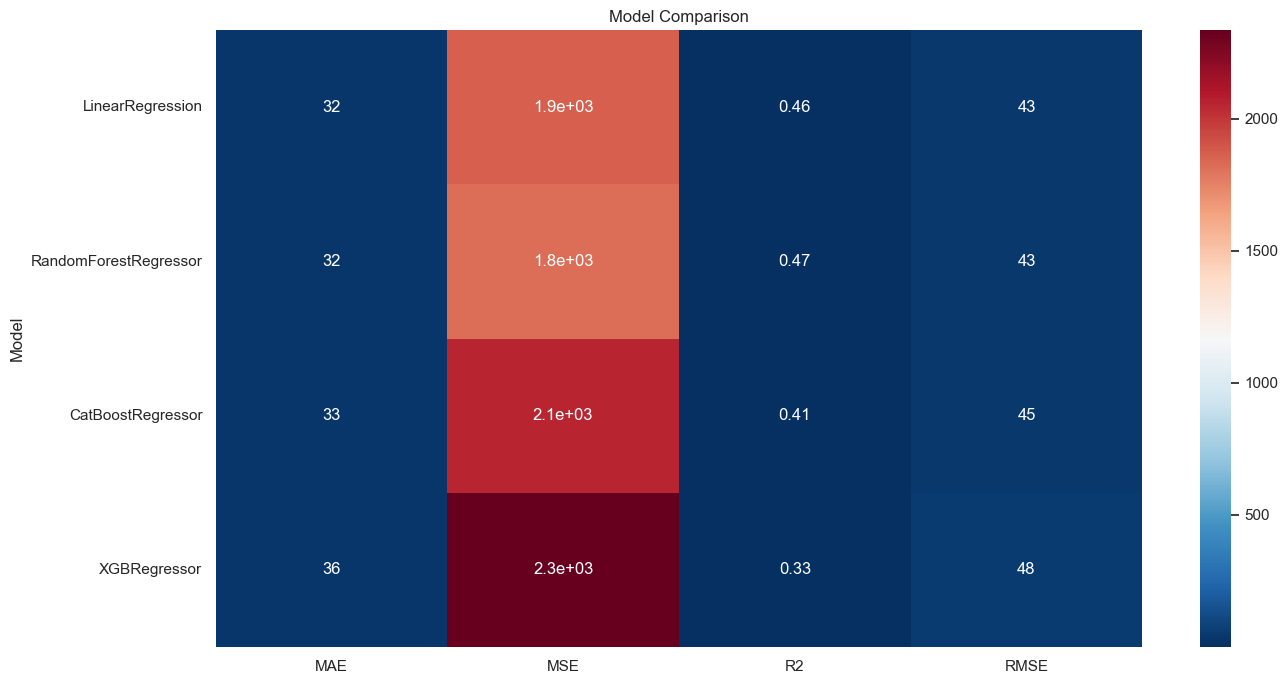

,Model,MAE,MSE,R2,RMSE
0,LinearRegression,32.039732,1868.149568,0.460176,43.222096
1,RandomForestRegressor,31.790319,1819.747544,0.474162,42.658499
2,CatBoostRegressor,33.344822,2053.837463,0.406519,45.319284
3,XGBRegressor,35.715404,2335.010943,0.325270,48.321951


In [200]:
# Train and evaluate the models
train_results = train_and_evaluate_models(models, features_train, target_train, features_test, target_test)

# Print the results
train_results

## Intermediate Conclusion

`LinearRegression` and `Random Forest` seem to be the models with the best performance in both the training set and the test set.

# General Conclusion

During this project for the taxi service `Sweet Lift Taxi`:

1. We conducted an exploratory data analysis, focusing on the variable `num_orders`. We resampled the data by hour to improve its quality.

2. We implemented and compared various regression models (`Linear Regression`, `Random Forest`, `CatBoost`, and `XGBoost`) to predict the number of taxi orders in the next hour.

3. We improved the accuracy of the models through hyperparameter tuning and added lagged and rolling mean features to better capture trends and seasonality in the data.

4. Although most of the models achieved an `RMSE` below the required threshold of **48**, we chose the `RandomForestRegressor` model as it had the `lowest RMSE` among our top two options, which was `42.65`.

In summary, we have developed a model that can predict with sufficient accuracy the number of taxi orders in the next hour, providing a valuable tool for Sweet Lift Taxi. This highlights the importance of careful data handling, effective feature engineering, and a balanced approach between model accuracy and efficiency.
